# Este Notebook solo funciona en colab

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

from google.colab import drive
from google.colab import files

import os
import shutil

from datetime import datetime

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
DRIVE_PATH = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/dataset'
BASE_PATH = 'dataset'

In [5]:
t0 = datetime.now()

if not os.path.exists(BASE_PATH):
  # os.mkdir(BASE_PATH)
  shutil.copytree(DRIVE_PATH,BASE_PATH)
  print('Data copied in',datetime.now()-t0)
else:
  print('El dataset ya existia')

Data copied in 0:06:11.524558


In [26]:
categories = os.listdir(BASE_PATH)
letters = sorted(os.listdir(os.path.join(BASE_PATH,categories[0])))
df = np.zeros((len(categories)*len(letters),3))
df = pd.DataFrame(df, columns=['Category','Letter','Count'])
# print(df[(0+1)*2])
row = 0
for i, category in enumerate(categories):
  for letter in letters:
    df.iloc[row,0] = category
    df.iloc[row,1] = letter
    df.iloc[row,2] = len(os.listdir(os.path.join(BASE_PATH,category, letter)))
    row+=1

<ipython-input-26-57f6e6ee4a9d>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[row,0] = category
<ipython-input-26-57f6e6ee4a9d>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[row,1] = letter


Letter  Category    Count
A       test        201.0    1
        train       499.0    1
        validation  200.0    1
B       test        201.0    1
        train       499.0    1
                            ..
del     train       476.0    1
        validation  110.0    1
space   test        201.0    1
        train       499.0    1
        validation  200.0    1
Name: count, Length: 84, dtype: int64

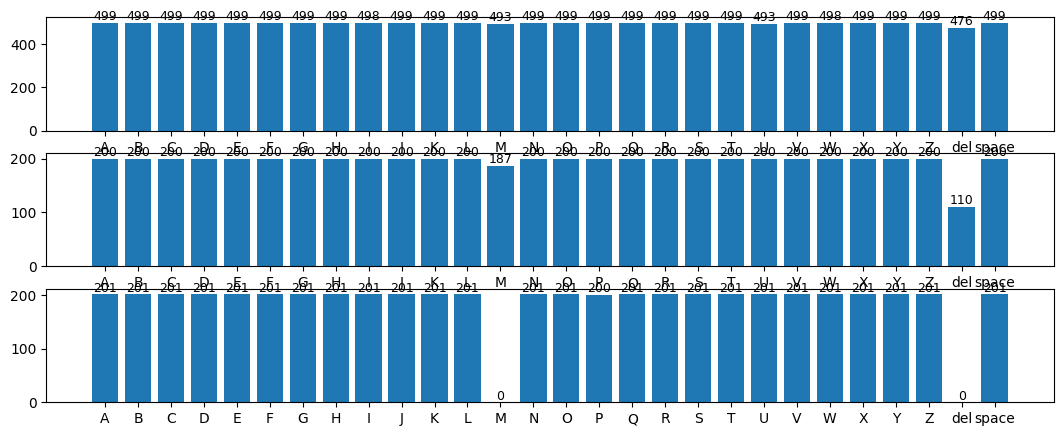

In [41]:
plt.figure(figsize=(13,5))
# plt.subplots(3)
for i,category in enumerate(['train','validation','test']):
  plt.subplot(3,1,i+1)
  bars = plt.bar(letters, df[df['Category']==category]['Count'])
  for bar in bars:
      height = int(bar.get_height())
      plt.text(bar.get_x() + bar.get_width()/2, height, str(height),
             ha='center', va='bottom', fontsize=9)
plt.show()

Excepto alguna letra del test los datos estan bien balanceados

In [ ]:
train_dir = os.path.join(BASE_PATH, 'train')
validation_dir = os.path.join(BASE_PATH, 'validation')
test_dir = os.path.join(BASE_PATH, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size =64,
    target_size=(300,300),
    class_mode= 'categorical',
    color_mode = 'rgb'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    target_size=(300,300),
    class_mode = 'categorical',
    color_mode = 'rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(300,300),
    class_mode='categorical',  # Asegúrate de que es el mismo class_mode que en train/val
    color_mode='rgb',
    shuffle=False  # No mezclar para mantener el orden de los archivos
)

Found 13935 images belonging to 28 classes.
Found 5497 images belonging to 28 classes.
Found 5225 images belonging to 28 classes.


In [ ]:
def evaluate_model(name, model, history):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=((10,5)))
  plt.plot(range(len(train_acc)),train_acc, 'o')
  plt.plot(range(len(train_acc)),val_acc, '-')
  plt.title('Train - Validation Accuracy')
  plt.legend(['Train','Validation'])
  plt.xticks(range(len(train_acc)))
  plt.grid(axis='x')

  plt.figure(figsize=((10,5)))
  plt.plot(range(len(train_acc)),train_loss, 'o')
  plt.plot(range(len(train_acc)),val_loss, '-')
  plt.title('Train - Validation Loss')
  plt.xticks(range(len(train_acc)))
  plt.legend(['Train','Validation'])
  plt.grid(axis='x')
  plt.show()


  y_pred = model.predict(test_generator)

  predicted_classes = np.argmax(y_pred,axis=1)
  class_labels = test_generator.class_indices.keys()

  cm = confusion_matrix(test_generator.classes, predicted_classes)

  plt.figure(figsize=(10,10))
  sns.heatmap(cm,annot=True, fmt='d',cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('Real')
  plt.title(f'Confusion matrix {name}')
  plt.show()

  test_loss, test_acc = model.evaluate(test_generator)
  print(f"Test Accuracy: {test_acc:.4f}"  )
  print(f"Max val Accuracy: {max(val_acc):.4f}"  )
  print(f"Max train Accuracy: {max(train_acc):.4f}"  )

In [ ]:
def save_model(name, model):
  name = 'ASP_'+name+'.keras'
  model.save(name)
  files.download(name)

## Training

In [ ]:
t0 = datetime.now()
model_1 = Sequential()

model_1.add(layers.Input(shape=(300,300,3)))

model_1.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_1.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_1.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_1.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_1.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_1.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_1.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(512,activation='relu'))
model_1.add(layers.Dense(28,'sigmoid'))
model_1.summary()

model_1.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

history_1 = model_1.fit(
    train_generator,
    steps_per_epoch = 250,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 60
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 296, 296, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 144, 144, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 70, 70, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 68, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,880,876 (14.80 MB)

 Trainable params: 3,880,876 (14.80 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
218/250 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.0665 - loss: 3.2743

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - accuracy: 0.0824 - loss: 3.2242 - val_accuracy: 0.5396 - val_loss: 1.6175
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.7975 - loss: 0.7477 - val_accuracy: 0.7628 - val_loss: 0.9540
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9336 - loss: 0.2369 - val_accuracy: 0.7979 - val_loss: 0.8691
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9647 - loss: 0.1051 - val_accuracy: 0.8031 - val_loss: 0.8695
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.9837 - loss: 0.0524 - val_accuracy: 0.8031 - val_loss: 1.4998
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.9880 - loss: 0.0500 - val_accuracy: 0.8195 - val_loss: 0.8889
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9916 - loss: 0.0322 - val_accuracy: 0.7979 - val_loss: 1.0815
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.9960 - loss: 0.0173 - val

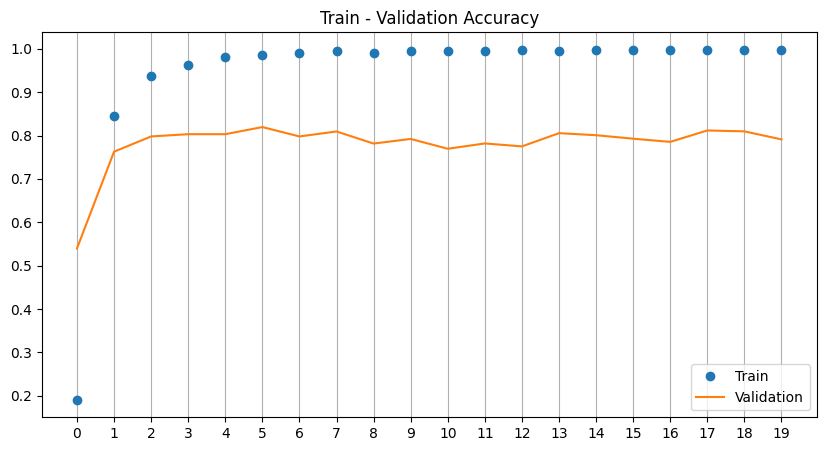

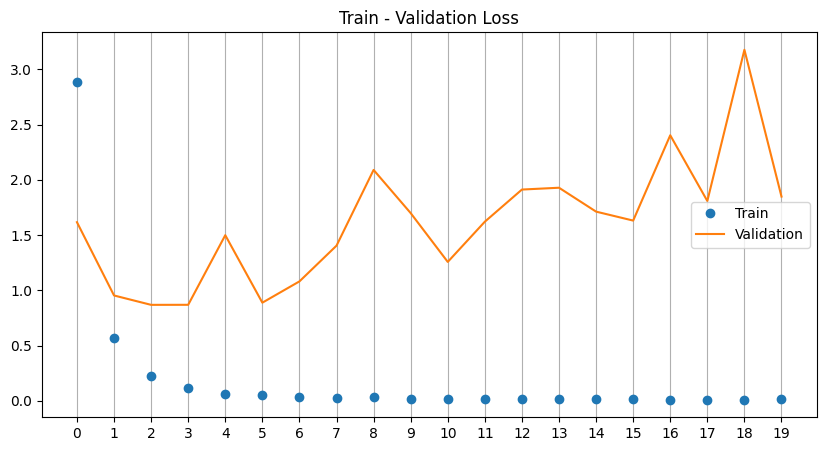

82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step


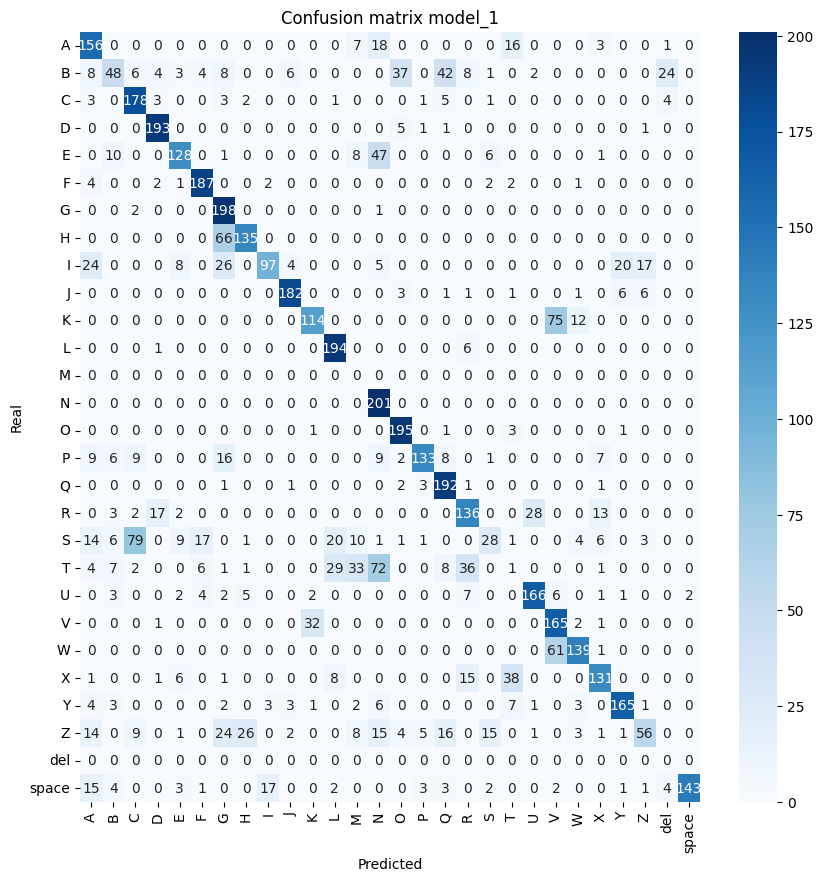

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.7288 - loss: 4.0120
Test Accuracy: 0.7007
Max val Accuracy: 0.8195
Max train Accuracy: 0.9978


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
evaluate_model('model_1',model_1,history_1)
save_model('model_1',model_1)

In [ ]:
t0 = datetime.now()
model_2 = Sequential()

model_2.add(layers.Input(shape=(300,300,3)))

# model_2.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_2.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_2.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_2.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_2.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_2.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
# model_2.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(512,activation='relu'))
model_2.add(layers.Dense(28,'softmax'))
model_2.summary()

model_2.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

history_2 = model_2.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 50,
    validation_data = validation_generator,
    # validation_steps = 100
)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_189 (Conv2D)             │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 145, 145, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_192 (Conv2D)             │ (None, 70, 70, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_193 (Conv2D)             │ (None, 68, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_194 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,468,124 (17.04 MB)

 Trainable params: 4,468,124 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.1424 - loss: 3.0735 - val_accuracy: 0.7406 - val_loss: 0.8969
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 217ms/step - accuracy: 0.8801 - loss: 0.4474 - val_accuracy: 0.8348 - val_loss: 0.6510
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.9573 - loss: 0.1659 - val_accuracy: 0.8166 - val_loss: 0.9863
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - accuracy: 0.9736 - loss: 0.0927 - val_accuracy: 0.8357 - val_loss: 0.8548
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9852 - loss: 0.0531 - val_accuracy: 0.8599 - val_loss: 0.8870
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - accuracy: 0.9885 - loss: 0.0401 - val_accuracy: 0.8830 - val_loss: 0.8411
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.9932 - loss: 0.0258 - val_accuracy: 0.8621 - val_loss: 1.0193
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.9950 - loss: 0

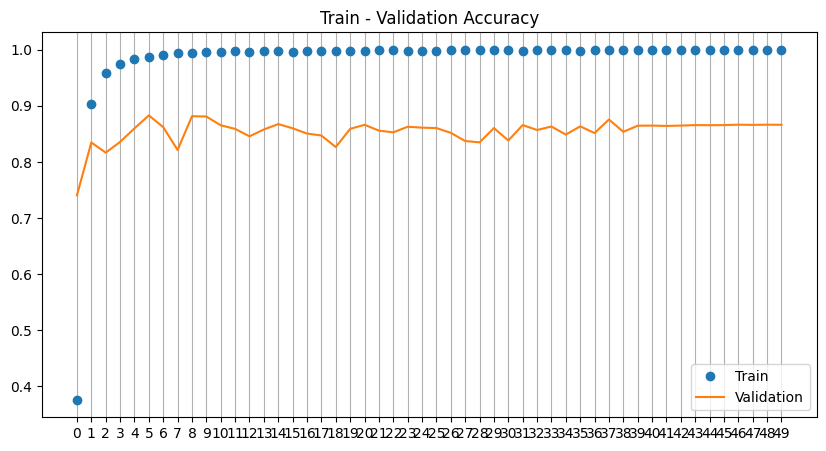

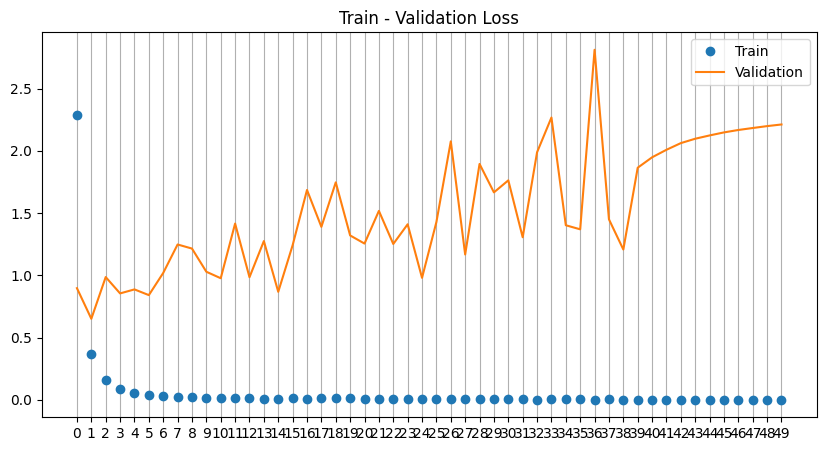

82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step


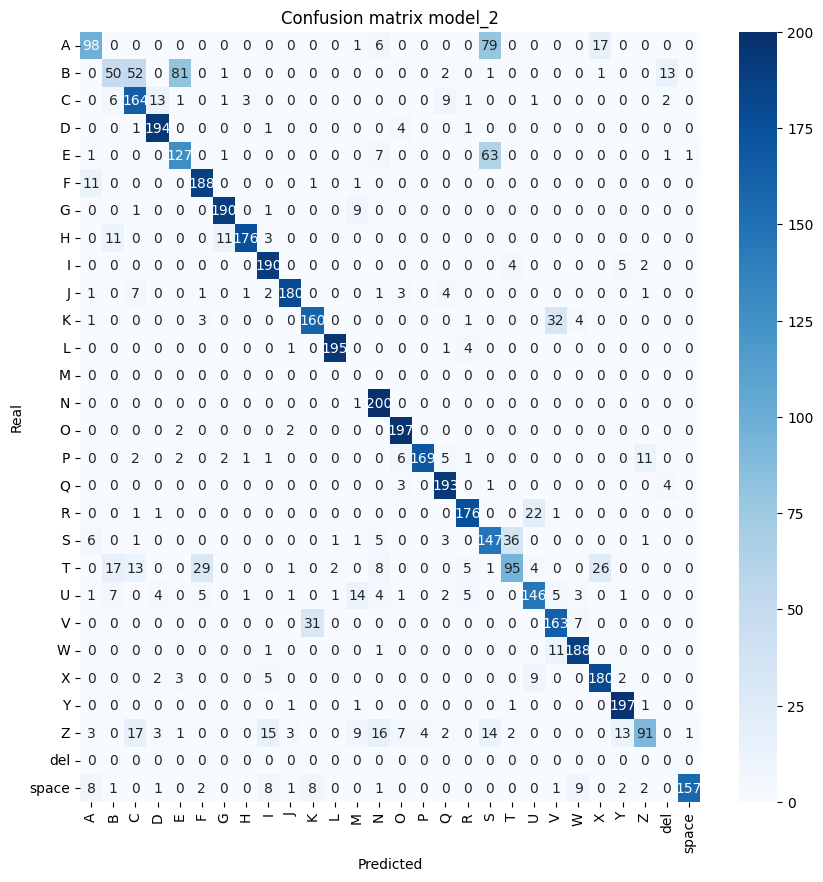

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7412 - loss: 4.7693
Test Accuracy: 0.8059
Max val Accuracy: 0.8830
Max train Accuracy: 1.0000


In [ ]:
evaluate_model('model_2',model_2,history_2)

In [ ]:
save_model('model_2',model_2)

In [ ]:
t0 = datetime.now()
model_3 = Sequential()

model_3.add(layers.Input(shape=(300,300,3)))

model_3.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_3.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_3.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_3.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_3.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_3.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_3.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(512,activation='relu'))
model_3.add(layers.Dense(28,'softmax'))
model_3.summary()

model_3.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

history_3 = model_3.fit(
    train_generator,
    steps_per_epoch = 250,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 60
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_178 (Conv2D)             │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 296, 296, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_181 (Conv2D)             │ (None, 144, 144, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_182 (Conv2D)             │ (None, 70, 70, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_183 (Conv2D)             │ (None, 68, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_184 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_185 (Conv2D)             │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_186 (Conv2D)             │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_187 (Conv2D)             │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,880,876 (14.80 MB)

 Trainable params: 3,880,876 (14.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
218/250 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.0379 - loss: 3.3333

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - accuracy: 0.0376 - loss: 3.3333 - val_accuracy: 0.0354 - val_loss: 3.3323
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.0318 - loss: 3.3327 - val_accuracy: 0.0380 - val_loss: 3.3316
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.0377 - loss: 3.3362 - val_accuracy: 0.0367 - val_loss: 3.3428
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.4787 - loss: 1.9051 - val_accuracy: 0.7201 - val_loss: 1.0360
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.9101 - loss: 0.3438 - val_accuracy: 0.8448 - val_loss: 0.7956
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.9611 - loss: 0.1490 - val_accuracy: 0.8510 - val_loss: 0.7970
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.9767 - loss: 0.0863 - val_accuracy: 0.8328 - val_loss: 1.1533
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9824 - loss: 0.0600 - val

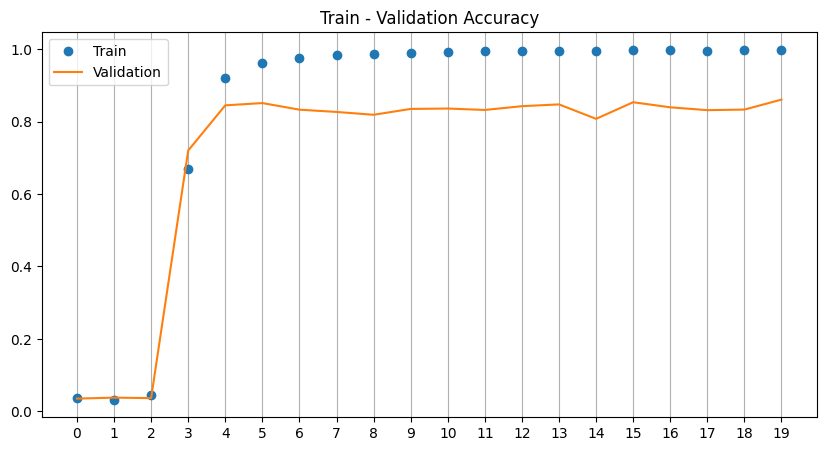

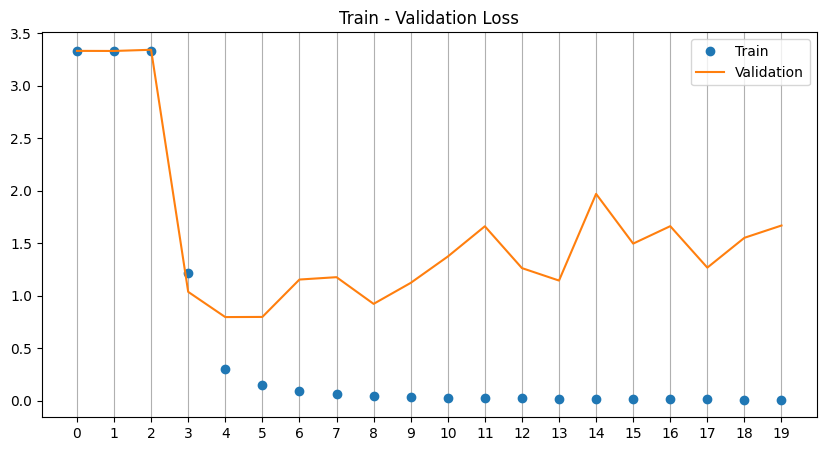

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step


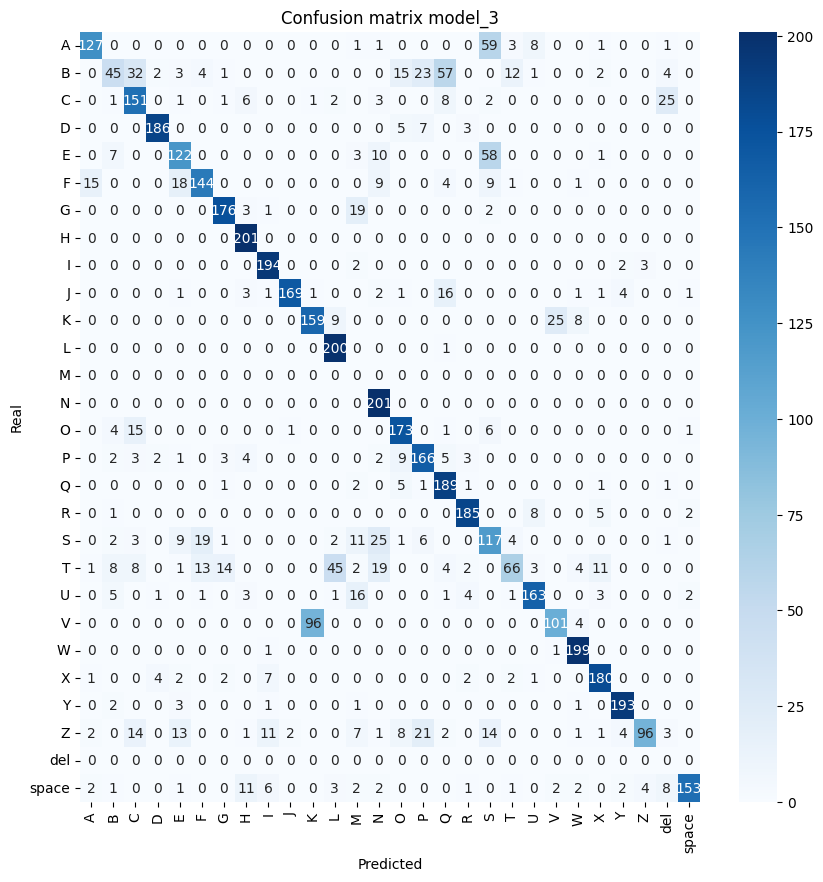

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.7314 - loss: 3.6558
Test Accuracy: 0.7763
Max val Accuracy: 0.8607
Max train Accuracy: 0.9981


In [ ]:
evaluate_model('model_3',model_3,history_3)

In [ ]:
save_model('model_3',model_3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_4 = Sequential()

model_4.add(layers.Input(shape=(300,300,3)))

model_4.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_4.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))

model_4.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_4.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))

model_4.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_4.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))

model_4.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_4.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))

model_4.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_4.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
# model_4.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(512,activation='relu'))
model_4.add(layers.Dense(28,'softmax'))
model_4.summary()

model_4.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights = True)
history_4 = model_4.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 50,
    validation_data = validation_generator,
    callbacks =early_stop,
    # validation_steps = 100
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_218 (Conv2D)             │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_219 (Conv2D)             │ (None, 296, 296, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_220 (Conv2D)             │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_221 (Conv2D)             │ (None, 144, 144, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_222 (Conv2D)             │ (None, 70, 70, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_223 (Conv2D)             │ (None, 68, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_224 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_225 (Conv2D)             │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_226 (Conv2D)             │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_227 (Conv2D)             │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,470,444 (17.05 MB)

 Trainable params: 4,470,444 (17.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 242ms/step - accuracy: 0.0969 - loss: 3.1523 - val_accuracy: 0.6900 - val_loss: 1.1116
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.8713 - loss: 0.5040 - val_accuracy: 0.7644 - val_loss: 0.9777
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9556 - loss: 0.1678 - val_accuracy: 0.7852 - val_loss: 1.0769
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.9775 - loss: 0.0828 - val_accuracy: 0.7875 - val_loss: 0.8378
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9865 - loss: 0.0530 - val_accuracy: 0.8086 - val_loss: 1.1302
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.9935 - loss: 0.0256 - val_accuracy: 0.8188 - val_loss: 0.9939
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 212ms/step - accuracy: 0.9934 - loss: 0.0216 - val_accuracy: 0.7877 - val_loss: 1.4464
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 213ms/step - accuracy: 0.9942 - loss: 0

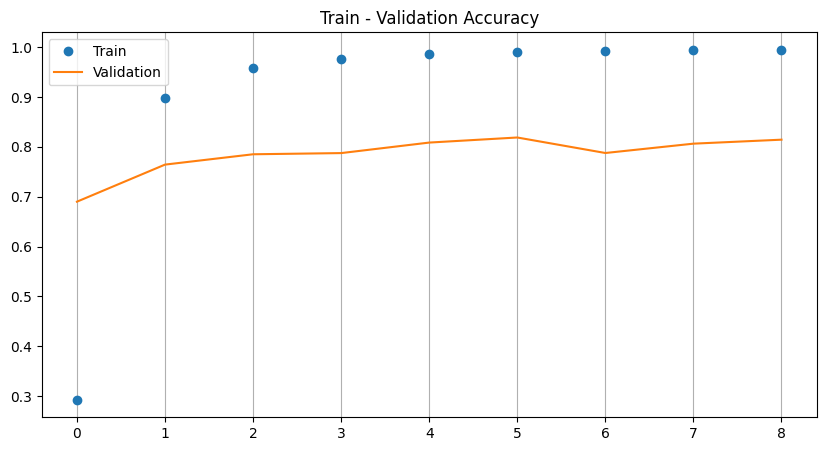

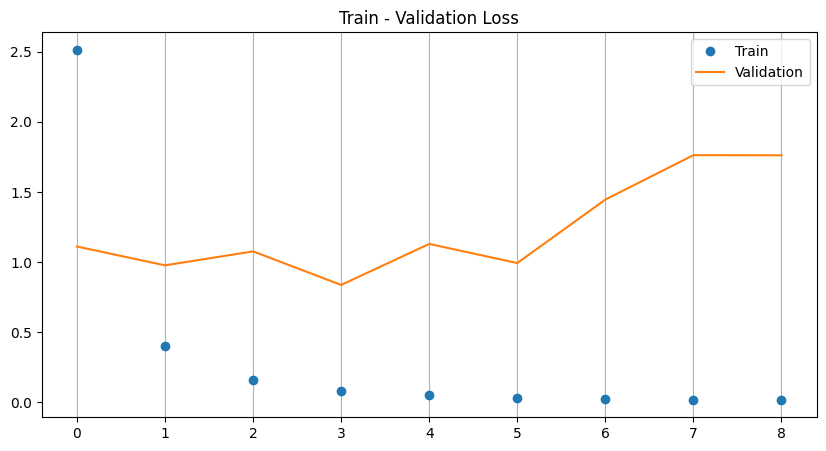

82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step


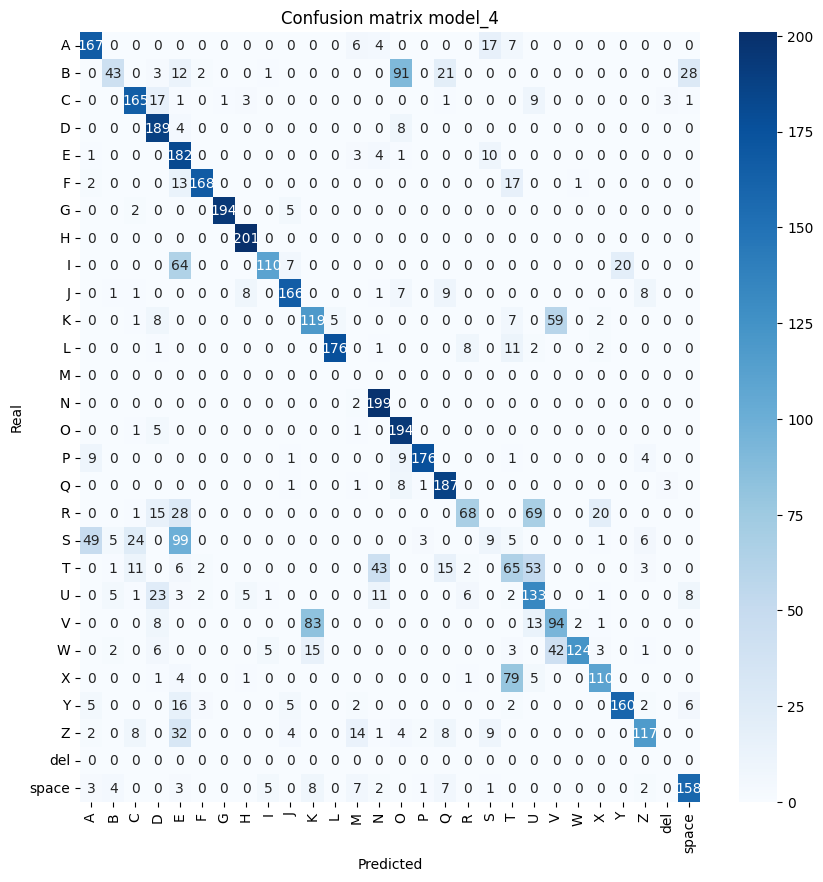

82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.7455 - loss: 1.3111
Test Accuracy: 0.7032
Max val Accuracy: 0.8188
Max train Accuracy: 0.9948


In [ ]:
evaluate_model('model_4',model_4,history_4 )

In [ ]:
t0 = datetime.now()
model_5 = Sequential()

model_5.add(layers.Input(shape=(300,300,3)))

# model_5.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_5.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))

# model_5.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_5.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))

# model_5.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_5.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))

# model_5.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_5.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))

# model_5.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_5.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
# mode5_4.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))

model_5.add(layers.Flatten())
model_5.add(layers.Dense(512,activation='relu'))
model_5.add(layers.Dense(28,'softmax'))
model_5.summary()

model_5.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights = True)
history_5 = model_5.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 50,
    validation_data = validation_generator,
    callbacks =early_stop,
    # validation_steps = 100
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_228 (Conv2D)             │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_229 (Conv2D)             │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_230 (Conv2D)             │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 35, 35, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_231 (Conv2D)             │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_232 (Conv2D)             │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 7, 7, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,830,012 (26.05 MB)

 Trainable params: 6,830,012 (26.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 56s 235ms/step - accuracy: 0.3586 - loss: 2.3294 - val_accuracy: 0.7337 - val_loss: 1.0676
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9435 - loss: 0.2140 - val_accuracy: 0.8194 - val_loss: 0.7038
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.9792 - loss: 0.0725 - val_accuracy: 0.7500 - val_loss: 1.3595
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 211ms/step - accuracy: 0.9888 - loss: 0.0377 - val_accuracy: 0.7941 - val_loss: 1.1268
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 213ms/step - accuracy: 0.9938 - loss: 0.0206 - val_accuracy: 0.7921 - val_loss: 1.1785
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 217ms/step - accuracy: 0.9981 - loss: 0.0095 - val_accuracy: 0.8026 - val_loss: 1.4206
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 48s 218ms/step - accuracy: 0.9968 - loss: 0.0133 - val_accuracy: 0.7557 - val_loss: 1.8438
Taks done in 0:05:37.417691


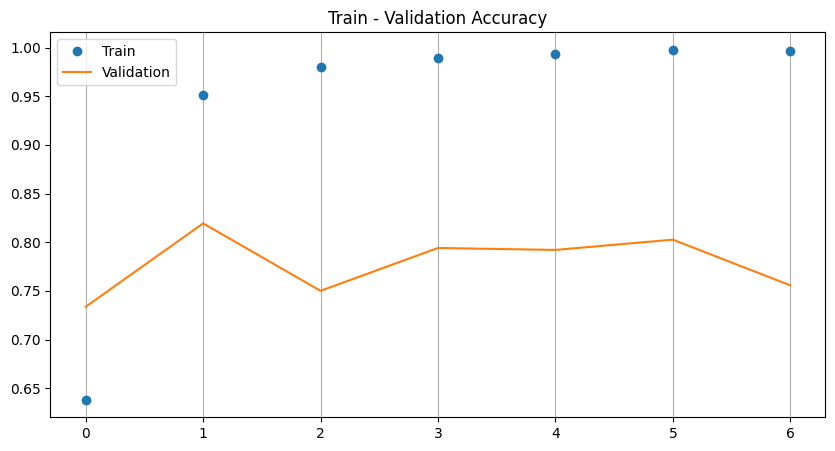

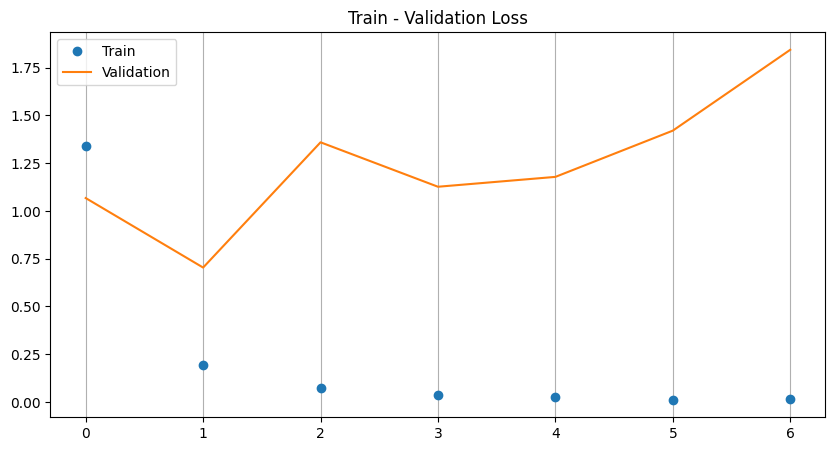

82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step


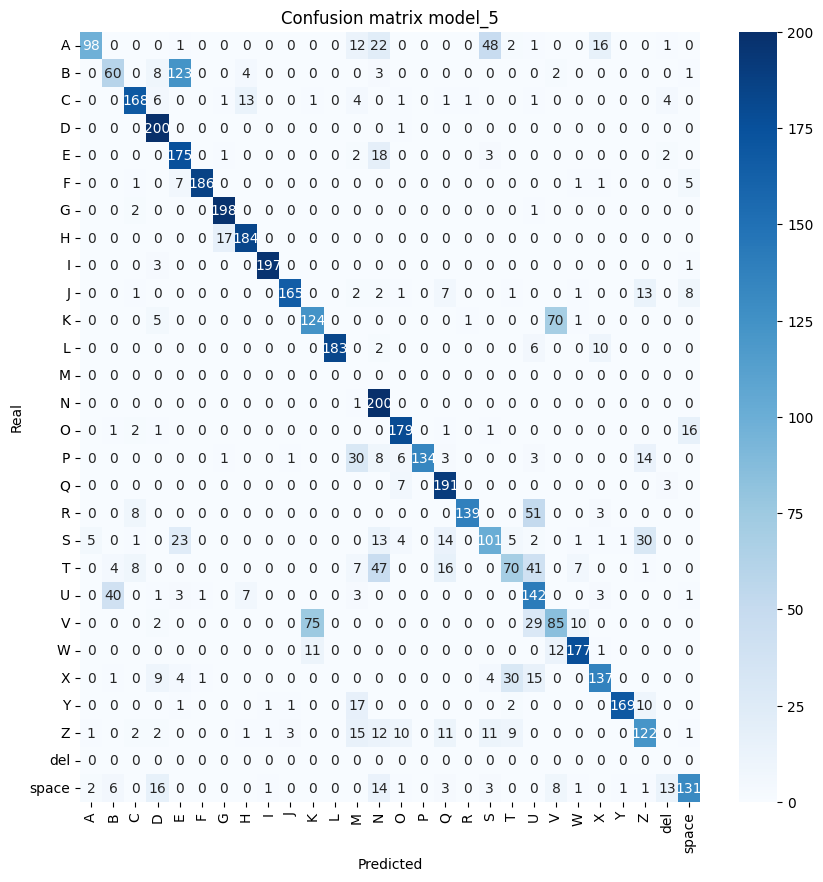

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.7426 - loss: 1.1252
Test Accuracy: 0.7493
Max val Accuracy: 0.8194
Max train Accuracy: 0.9977


In [ ]:
evaluate_model('model_5',model_5,history_5 )

In [ ]:
save_model('model_5',model_5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_6 = Sequential()

model_6.add(layers.Input(shape=(300,300,3)))

model_6.add(layers.Conv2D(8, kernel_size=(3,3),activation='relu'))
model_6.add(layers.MaxPool2D(pool_size=(2,2)))

model_6.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_6.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu'))
model_6.add(layers.MaxPool2D(pool_size=(2,2)))

# model_6.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_6.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu'))
model_6.add(layers.MaxPool2D(pool_size=(2,2)))

# model_6.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_6.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu'))
model_6.add(layers.MaxPool2D(pool_size=(2,2)))

model_6.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_6.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu'))
model_6.add(layers.MaxPool2D(pool_size=(2,2)))

model_6.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_6.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
# model_6.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu'))
model_6.add(layers.MaxPool2D(pool_size=(2,2)))

model_6.add(layers.Flatten())
model_6.add(layers.Dense(512,activation='relu'))
model_6.add(layers.Dense(28,'softmax'))

model_6.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience = 10,
    restore_best_weights = True)
history_6 = model_6.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 50,
    validation_data = validation_generator,
    callbacks =early_stop,
    # validation_steps = 100
)
print(f'Taks done in {datetime.now()-t0}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 239ms/step - accuracy: 0.1782 - loss: 2.8751 - val_accuracy: 0.6916 - val_loss: 1.2737
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.8661 - loss: 0.4961 - val_accuracy: 0.7844 - val_loss: 1.0159
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.9400 - loss: 0.2110 - val_accuracy: 0.7943 - val_loss: 1.0583
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9697 - loss: 0.1026 - val_accuracy: 0.7584 - val_loss: 1.3847
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.9784 - loss: 0.0715 - val_accuracy: 0.8048 - val_loss: 1.0913
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.9856 - loss: 0.0502 - val_accuracy: 0.7877 - val_loss: 1.4800
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9895 - loss: 0.0349 - val_accuracy: 0.8415 - val_loss: 1.1169
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 217ms/step - accuracy: 0.9914 - loss: 0

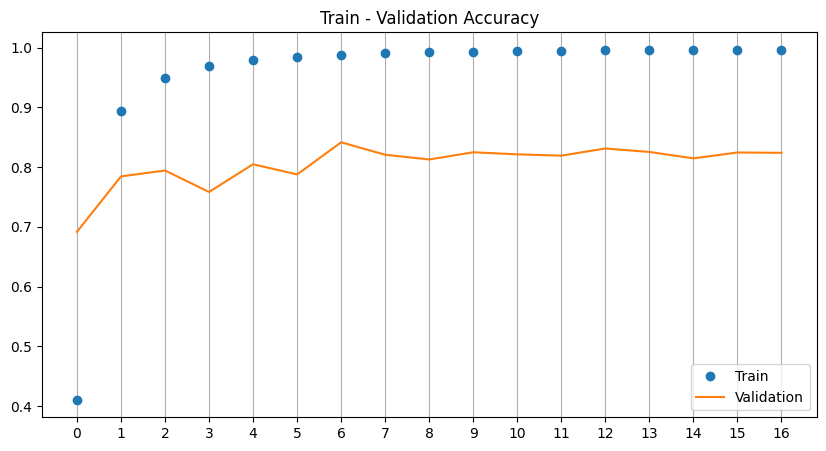

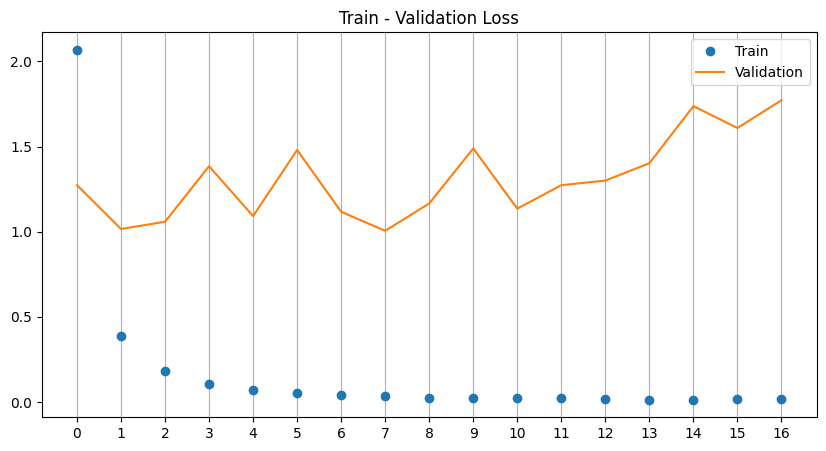

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step


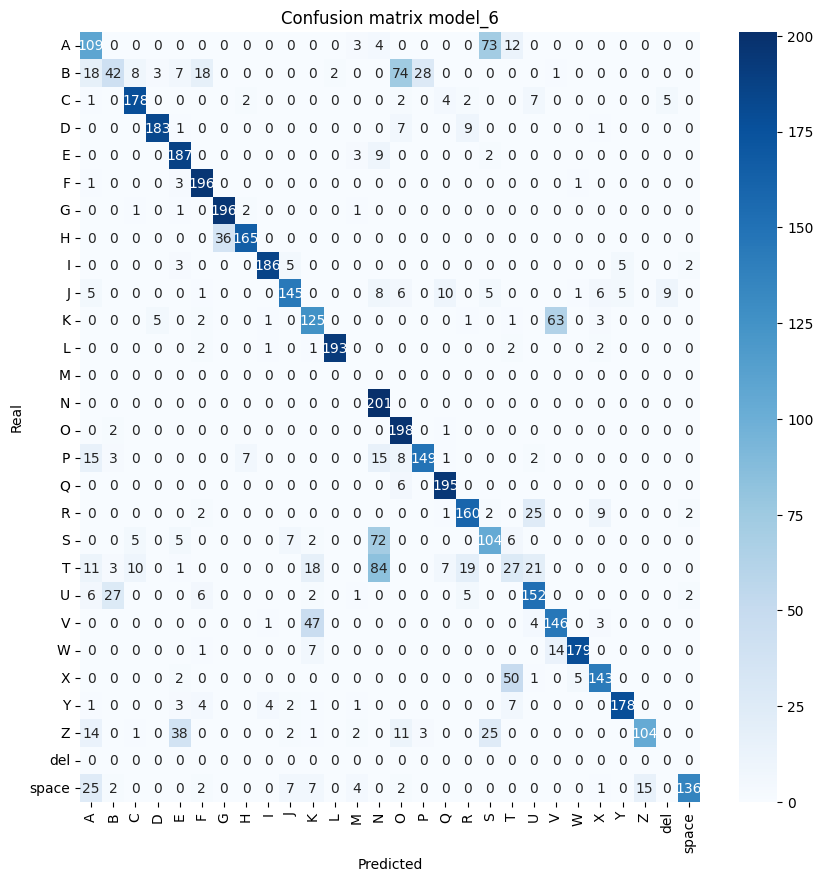

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.7423 - loss: 2.4830
Test Accuracy: 0.7611
Max val Accuracy: 0.8415
Max train Accuracy: 0.9964


In [ ]:
evaluate_model('model_6',model_6,history_6)

In [ ]:
save_model('model_6',model_6)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_7 = Sequential()

model_7.add(layers.Input(shape=(300,300,3)))

model_7.add(layers.Conv2D(8, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Dropout(0.3))

model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Dropout(0.3))

model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
# model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
# model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Flatten())
model_7.add(layers.Dense(512,activation='relu'))
model_7.add(layers.Dense(28,'softmax'))

model_7.summary()

model_7.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience = 20,
    restore_best_weights = True)
history_7 = model_7.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 100,
    validation_data = validation_generator,
    callbacks =early_stop,
    validation_steps = 100
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_289 (Conv2D)             │ (None, 300, 300, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_132               │ (None, 150, 150, 8)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_290 (Conv2D)             │ (None, 150, 150, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_291 (Conv2D)             │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_133               │ (None, 75, 75, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_292 (Conv2D)             │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_293 (Conv2D)             │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_134               │ (None, 37, 37, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_294 (Conv2D)             │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_295 (Conv2D)             │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_296 (Conv2D)             │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_135               │ (None, 18, 18, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_297 (Conv2D)             │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_298 (Conv2D)             │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_299 (Conv2D)             │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 9, 9, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_300 (Conv2D)             │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 4, 4, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │     2,097,66

 Total params: 2,886,172 (11.01 MB)

 Trainable params: 2,886,172 (11.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 238ms/step - accuracy: 0.0365 - loss: 3.3337 - val_accuracy: 0.0364 - val_loss: 3.3322
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 210ms/step - accuracy: 0.1830 - loss: 2.8888 - val_accuracy: 0.6333 - val_loss: 1.3423
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.8786 - loss: 0.4458 - val_accuracy: 0.7395 - val_loss: 1.1405
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.9551 - loss: 0.1630 - val_accuracy: 0.7935 - val_loss: 0.9864
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 46s 212ms/step - accuracy: 0.9743 - loss: 0.0797 - val_accuracy: 0.7828 - val_loss: 1.0395
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.9809 - loss: 0.0622 - val_accuracy: 0.7702 - val_loss: 1.4180
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.9893 - loss: 0.0389 - val_accuracy: 0.8079 - val_loss: 1.2794
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.9884 -

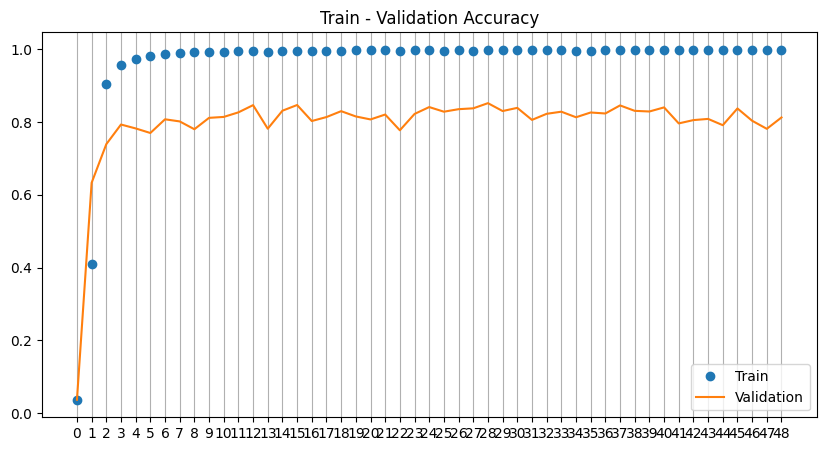

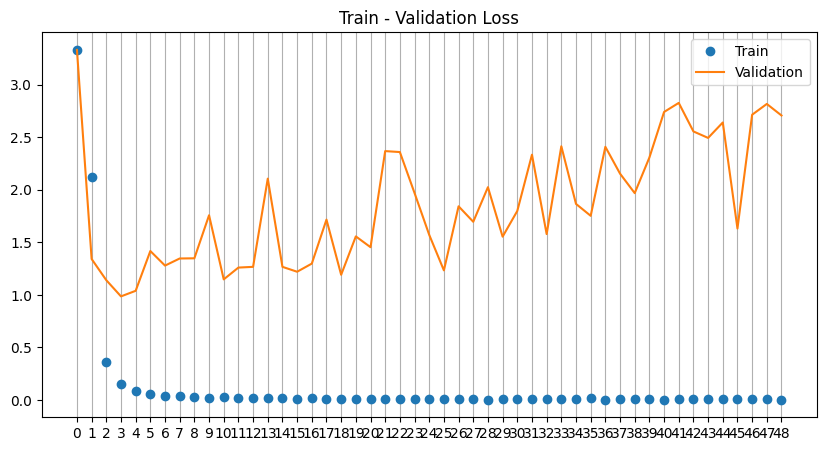

82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step


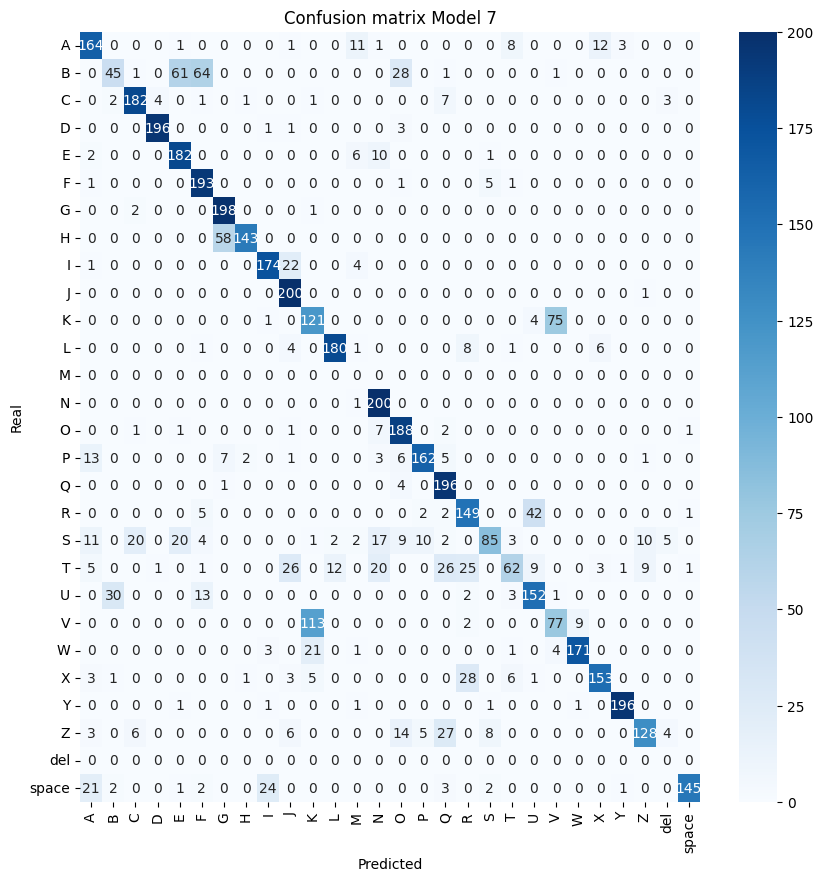

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.7872 - loss: 3.3345
Test Accuracy: 0.7736
Max val Accuracy: 0.8523
Max train Accuracy: 0.9991


In [ ]:
evaluate_model('Model 7',model_7,history_7)

In [ ]:
save_model('model_7',model_7)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>